# Solar energy forecasting

## Importing libraries

In [109]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Single PV module datasets (weather/power) in Italy

In [110]:
data_f = pd.read_csv('pv module data.csv', parse_dates=[0])
data_f = data_f.set_index("Time") # set Datetime as an index
data_f

,PV_Power,T_air,G_h,G_tilt,W_s,W_d
Time,,,,,,
2017-01-01 00:00:00,NaN,0.74,0.0,0.0,0.30,296.4
2017-01-01 00:01:00,NaN,0.67,0.0,0.0,0.47,269.2
2017-01-01 00:02:00,NaN,0.57,0.0,0.0,0.84,265.3
2017-01-01 00:03:00,NaN,0.53,0.0,0.0,0.63,275.4
2017-01-01 00:04:00,NaN,0.53,0.0,0.0,0.58,265.3
...,...,...,...,...,...,...
2017-12-31 23:56:00,NaN,2.91,0.0,0.0,0.41,68.2
2017-12-31 23:57:00,NaN,2.85,0.0,0.0,1.01,42.8
2017-12-31 23:58:00,NaN,2.83,0.0,0.0,1.22,46.6


### Resampling datasets with 1-hour time interval

In [111]:
data=data_f.fillna(0)
data=data.resample('1H',closed='left').asfreq()[0:]
data

,PV_Power,T_air,G_h,G_tilt,W_s,W_d
Time,,,,,,
2017-01-01 00:00:00,0.0,0.74,0.0,0.0,0.30,296.4
2017-01-01 01:00:00,0.0,0.41,0.0,0.0,0.58,318.3
2017-01-01 02:00:00,0.0,-0.33,0.0,0.0,0.00,30.5
2017-01-01 03:00:00,0.0,0.48,0.0,0.0,0.25,352.1
2017-01-01 04:00:00,0.0,-0.19,0.0,0.0,0.52,331.8
...,...,...,...,...,...,...
2017-12-31 20:00:00,0.0,4.28,0.0,0.0,0.63,63.1
2017-12-31 21:00:00,0.0,3.49,0.0,0.0,0.90,23.1
2017-12-31 22:00:00,0.0,3.78,0.0,0.0,0.25,298.9


### Extracting datetime features to perform important feature selection

In [112]:
#Extracting some features from the date/time
final_df = (data.assign(year = data.index.year
                        ,month = data.index.month
                     ,day = data.index.day
                     ,day_of_year = data.index.dayofyear
                     ,week = data.index.isocalendar().week
                     ,week_day = data.index.weekday 
                     ,quarter = data.index.quarter
                     ,hour=data.index.hour )
           )

final_df

,PV_Power,T_air,G_h,G_tilt,W_s,W_d,year,month,day,day_of_year,week,week_day,quarter,hour
Time,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,0.74,0.0,0.0,0.30,296.4,2017,1,1,1,52,6,1,0
2017-01-01 01:00:00,0.0,0.41,0.0,0.0,0.58,318.3,2017,1,1,1,52,6,1,1
2017-01-01 02:00:00,0.0,-0.33,0.0,0.0,0.00,30.5,2017,1,1,1,52,6,1,2
2017-01-01 03:00:00,0.0,0.48,0.0,0.0,0.25,352.1,2017,1,1,1,52,6,1,3
2017-01-01 04:00:00,0.0,-0.19,0.0,0.0,0.52,331.8,2017,1,1,1,52,6,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 20:00:00,0.0,4.28,0.0,0.0,0.63,63.1,2017,12,31,365,52,6,4,20
2017-12-31 21:00:00,0.0,3.49,0.0,0.0,0.90,23.1,2017,12,31,365,52,6,4,21
2017-12-31 22:00:00,0.0,3.78,0.0,0.0,0.25,298.9,2017,12,31,365,52,6,4,22


### January 2017 solar power for training the model

In [113]:
solar_gen6=final_df.loc[final_df['month'].isin([1])].iloc[:,0]
solar_gen6.drop(solar_gen6.tail(1).index,inplace=True)
solar_gen6

Time
2017-01-01 00:00:00    0.0
2017-01-01 01:00:00    0.0
2017-01-01 02:00:00    0.0
2017-01-01 03:00:00    0.0
2017-01-01 04:00:00    0.0
                      ... 
2017-01-31 19:00:00    0.0
2017-01-31 20:00:00    0.0
2017-01-31 21:00:00    0.0
2017-01-31 22:00:00    0.0
2017-01-31 23:00:00    0.0
Name: PV_Power, Length: 744, dtype: float64

### Weather features

In [114]:
feature_sol6=final_df.loc[final_df['month'].isin([1])].iloc[:,1:]
feature_sol6.drop(feature_sol6.tail(1).index,inplace=True)
feature_sol6

,T_air,G_h,G_tilt,W_s,W_d,year,month,day,day_of_year,week,week_day,quarter,hour
Time,,,,,,,,,,,,,
2017-01-01 00:00:00,0.74,0.0,0.0,0.30,296.4,2017,1,1,1,52,6,1,0
2017-01-01 01:00:00,0.41,0.0,0.0,0.58,318.3,2017,1,1,1,52,6,1,1
2017-01-01 02:00:00,-0.33,0.0,0.0,0.00,30.5,2017,1,1,1,52,6,1,2
2017-01-01 03:00:00,0.48,0.0,0.0,0.25,352.1,2017,1,1,1,52,6,1,3
2017-01-01 04:00:00,-0.19,0.0,0.0,0.52,331.8,2017,1,1,1,52,6,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-31 19:00:00,5.03,0.0,0.0,0.84,269.8,2017,1,31,31,5,1,1,19
2017-01-31 20:00:00,5.11,0.0,0.0,0.63,243.3,2017,1,31,31,5,1,1,20
2017-01-31 21:00:00,4.81,0.0,0.0,0.00,313.3,2017,1,31,31,5,1,1,21


### Using Gradient boosting regressor to select most important features for forecasting

 0    T_air= 0.09
 1      G_h= 0.26
 2   G_tilt= 0.43
 3      W_s= 0.05
 4      W_d= 0.02
 5     year= 0.00
 6    month= 0.00
 7      day= 0.03
 8 day_of_year= 0.03
 9     week= 0.04
10 week_day= 0.01
11  quarter= 0.00
12     hour= 0.03


C:\Users\TALAL.Talal.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


<StemContainer object of 3 artists>

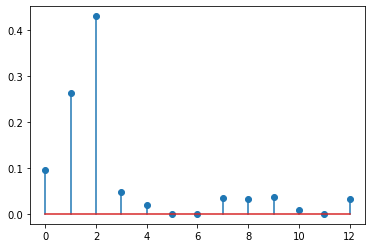

In [115]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

#Calculating feature importance
X_train,X_test,y_train,y_test=train_test_split(feature_sol6,solar_gen6,train_size=0.75,test_size=0.25,random_state=0,shuffle=False)

gbr = GradientBoostingRegressor(max_features=2,random_state=0)
gbr.fit(X_train, y_train)
for i in range(len(feature_sol6.columns)):
    print("%2d %8s=%5.2f" % (i,feature_sol6.columns[i], gbr.feature_importances_[i]))
plt.stem(gbr.feature_importances_)


## Removing less important features

In [116]:
cols = [4,5,6,7,8,9,10,11,12]
feature_sol6=feature_sol6.drop(feature_sol6.columns[cols],axis=1)
feature_sol6

,T_air,G_h,G_tilt,W_s
Time,,,,
2017-01-01 00:00:00,0.74,0.0,0.0,0.30
2017-01-01 01:00:00,0.41,0.0,0.0,0.58
2017-01-01 02:00:00,-0.33,0.0,0.0,0.00
2017-01-01 03:00:00,0.48,0.0,0.0,0.25
2017-01-01 04:00:00,-0.19,0.0,0.0,0.52
...,...,...,...,...
2017-01-31 19:00:00,5.03,0.0,0.0,0.84
2017-01-31 20:00:00,5.11,0.0,0.0,0.63
2017-01-31 21:00:00,4.81,0.0,0.0,0.00


## Forecasting Solar generation using GBR

In [117]:
#libraries for MLPR and accuracies check
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

### Splitting datasets into test and train set

In [118]:
#Splitting data into train and test set
X_train,X_test,y_train,y_test=train_test_split(feature_sol6,solar_gen6,train_size=0.75,test_size=0.25,random_state=0,shuffle=False)

CV score.......... 0.9293893090744267
Training score.... 0.9314137854464505
Test score........ 0.9121266237776052


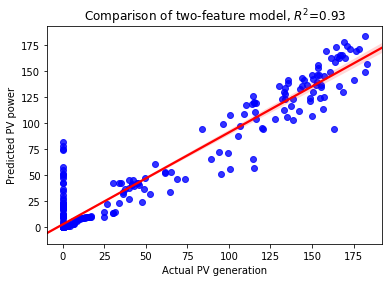

In [119]:

gbr = GradientBoostingRegressor(max_features=3,learning_rate= 0.05,random_state=1,subsample=0.5)

gbr.fit(X_train, y_train)
yhat=gbr.predict(X_train)

RsquaredCV=cross_val_score(gbr, X_test, y_test, cv=5).mean()
RsquaredTR=gbr.score(X_train,y_train)

sns.regplot(x=y_train,y=yhat, line_kws={"color": "red"},scatter_kws={"color": "blue"})
yhat=gbr.predict(X_test)
plt.xlabel('Actual PV generation')
plt.ylabel('Predicted PV power')
plt.title('Comparison of two-feature model, $R^2$=%3.2f' % RsquaredCV)
print("CV score..........", RsquaredCV)
print("Training score....", RsquaredTR)
print("Test score........",r2_score(y_true=y_test,y_pred=yhat))

### Plotting January 2017 predicted vs actual power generation

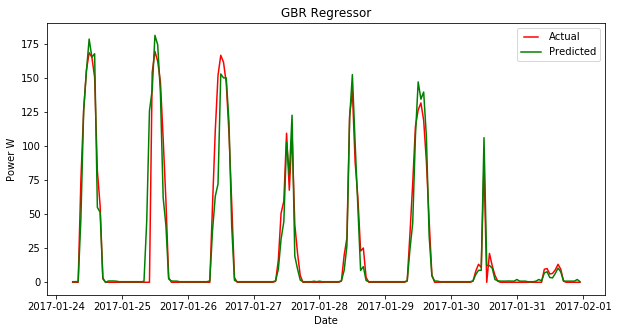

In [120]:
from matplotlib.legend_handler import HandlerLine2D
from pandas.plotting import register_matplotlib_converters

yhat=pd.DataFrame(yhat,columns=['Predicted Energy'])
yhat.index=y_test.index

#Plotting predicted solar production
plt.figure(figsize=(10,5))
line1,=plt.plot(y_test,'r',label='Actual')
line2,=plt.plot(yhat,'green',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Power W')
plt.title('GBR Regressor')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

## Verifiying model accuracy by predicting Febraury 2017

In [121]:
solar_gen_mar=final_df.loc[final_df['month'].isin([3])].iloc[:,0]
feature_sol_mar=final_df.loc[final_df['month'].isin([3])].iloc[:,1:]
feature_sol_mar=feature_sol_mar.drop(feature_sol_mar.columns[cols],axis=1)
feature_sol_mar

,T_air,G_h,G_tilt,W_s
Time,,,,
2017-03-01 00:00:00,5.99,0.0,0.0,1.17
2017-03-01 01:00:00,6.55,0.0,0.0,3.17
2017-03-01 02:00:00,6.48,0.0,0.0,4.36
2017-03-01 03:00:00,6.83,0.0,0.0,3.69
2017-03-01 04:00:00,6.04,0.0,0.0,3.02
...,...,...,...,...
2017-03-31 19:00:00,21.30,0.0,0.0,0.79
2017-03-31 20:00:00,20.35,0.0,0.0,0.58
2017-03-31 21:00:00,18.85,0.0,0.0,1.59


CV score.......... 0.8810635310235805
Test score........ 0.8852740873987784


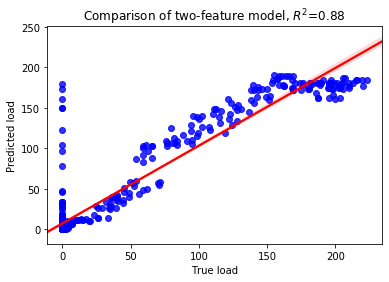

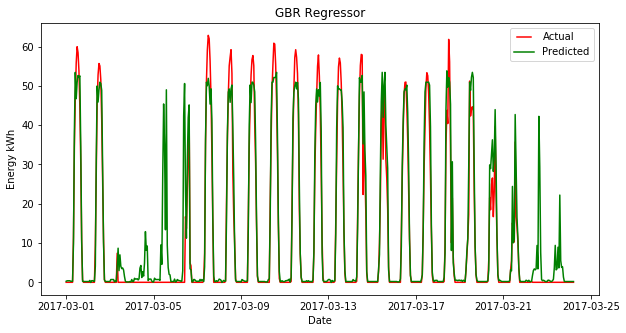

In [122]:
X_orig,X_no,y_orig,y_no=train_test_split(feature_sol_mar,solar_gen_mar,train_size=0.75,random_state=0,shuffle=False)

yhat=gbr.predict(X_orig)

RsquaredCV=cross_val_score(gbr, X_orig, y_orig, cv=5).mean()

sns.regplot(x=y_orig,y=yhat, line_kws={"color": "red"},scatter_kws={"color": "blue"})

plt.xlabel('True load')
plt.ylabel('Predicted load')
plt.title('Comparison of two-feature model, $R^2$=%3.2f' % RsquaredCV)
print("CV score..........", RsquaredCV)
print("Test score........",r2_score(y_true=y_orig,y_pred=yhat))

yhat=pd.DataFrame(yhat,columns=['Predicted Energy'])
yhat.index=y_orig.index
#Plotting predicted solar production
plt.figure(figsize=(10,5))
line1,=plt.plot(y_orig*(282/1000),'r',label='Actual')
line2,=plt.plot(yhat*(282/1000),'green',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Energy kWh')
plt.title('GBR Regressor')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

# 2017 Konstanz, Germany solar power forecast

## Importing Konstanz weather data

In [123]:
wea_data = pd.read_csv('Weather data konstanz.csv', parse_dates=[1])
wea_data = wea_data.set_index("PeriodStart") # set Datetime as an index
wea_data.drop(['PeriodEnd','Period'], inplace=True, axis=1)
wea_data= wea_data.fillna(0)
wea_data

,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,GtiTracking,PrecipitableWater,RelativeHumidity,SnowDepth,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith
PeriodStart,,,,,,,,,,,,,,,,,,
2015-12-31 01:00:00+00:00,0.4,0.13,-56,0.0,-3.4,0,0,0,0,0,0,6.5,75.4,0.3,928.6,178,3.7,145
2015-12-31 02:00:00+00:00,0.3,0.13,-73,0.0,-4.6,0,0,0,0,0,0,7.3,70.1,0.3,928.7,182,4.0,136
2015-12-31 03:00:00+00:00,0.3,0.13,-85,0.0,-5.0,0,0,0,0,0,0,8.3,67.5,0.3,928.9,185,4.0,126
2015-12-31 04:00:00+00:00,0.6,0.13,-97,41.8,-4.7,0,0,0,0,0,0,9.6,67.5,0.3,929.0,190,3.9,116
2015-12-31 05:00:00+00:00,0.9,0.13,-107,75.6,-4.4,0,0,0,0,0,0,10.9,67.5,0.3,929.1,194,3.8,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-16 17:00:00+00:00,8.7,0.17,75,61.4,8.1,62,0,0,62,57,62,17.6,96.1,0.0,944.6,177,2.5,78
2021-05-16 18:00:00+00:00,8.0,0.17,64,64.0,7.5,14,0,0,14,13,14,17.8,96.7,0.0,944.4,166,1.9,87
2021-05-16 19:00:00+00:00,7.7,0.17,53,72.2,7.3,0,0,0,0,0,0,18.3,97.3,0.0,944.8,214,1.2,96


In [124]:
#Extracting some features from the date/time
final_df = (wea_data.assign(year = wea_data.index.year
                        ,month = wea_data.index.month
                     ,day = wea_data.index.day
                     ,day_of_year = wea_data.index.dayofyear
                     ,week = wea_data.index.isocalendar().week
                     ,week_day = wea_data.index.weekday 
                     ,quarter = wea_data.index.quarter)
           )

final_df.tail()

,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,...,WindDirection10m,WindSpeed10m,Zenith,year,month,day,day_of_year,week,week_day,quarter
PeriodStart,,,,,,,,,,,,,,,,,,,,,
2021-05-16 17:00:00+00:00,8.7,0.17,75,61.4,8.1,62,0,0,62,57,...,177,2.5,78,2021,5,16,136,19,6,2
2021-05-16 18:00:00+00:00,8.0,0.17,64,64.0,7.5,14,0,0,14,13,...,166,1.9,87,2021,5,16,136,19,6,2
2021-05-16 19:00:00+00:00,7.7,0.17,53,72.2,7.3,0,0,0,0,0,...,214,1.2,96,2021,5,16,136,19,6,2
2021-05-16 20:00:00+00:00,8.2,0.17,41,67.1,7.7,0,0,0,0,0,...,238,2.5,103,2021,5,16,136,19,6,2
2021-05-16 21:00:00+00:00,8.1,0.17,27,40.8,7.3,0,0,0,0,0,...,240,3.7,109,2021,5,16,136,19,6,2


In [125]:
feature_konz=final_df.loc[final_df['year'].isin([2017])]
feature_konz=feature_konz.loc[feature_konz['month'].isin([2])]
feature_konz=feature_konz[['AirTemp','Ghi','GtiFixedTilt','WindSpeed10m']]
feature_konz

,AirTemp,Ghi,GtiFixedTilt,WindSpeed10m
PeriodStart,,,,
2017-02-01 00:00:00+00:00,3.0,0,0,0.7
2017-02-01 01:00:00+00:00,2.3,0,0,0.8
2017-02-01 02:00:00+00:00,1.6,0,0,1.0
2017-02-01 03:00:00+00:00,1.3,0,0,1.1
2017-02-01 04:00:00+00:00,1.3,0,0,1.1
...,...,...,...,...
2017-02-28 19:00:00+00:00,1.6,0,0,7.7
2017-02-28 20:00:00+00:00,1.2,0,0,7.9
2017-02-28 21:00:00+00:00,1.1,0,0,7.5


## Forecasting February 2017 PV production using GBR in Konstanz

### Plot of forecasted data

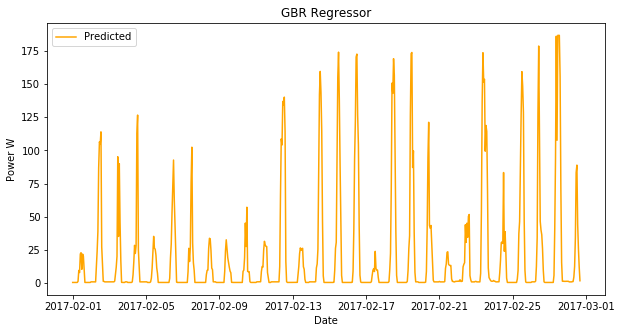

In [126]:
X_orig,X_no,y_orig,y_no=train_test_split(feature_konz,feature_konz,train_size=.99,random_state=0,shuffle=False)

yhat=gbr.predict(X_orig)

yhat=pd.DataFrame(yhat,columns=['Predicted Energy Wh'])
yhat.index=X_orig.index

#Plotting predicted solar production
plt.figure(figsize=(10,5))
line2,=plt.plot(yhat,'orange',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Power W')
plt.title('GBR Regressor')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

In [127]:
feature_konz=final_df.loc[final_df['year'].isin([2017])]
feature_konz=feature_konz[['AirTemp','Ghi','GtiFixedTilt','WindSpeed10m']]
feature_konz

,AirTemp,Ghi,GtiFixedTilt,WindSpeed10m
PeriodStart,,,,
2017-01-01 00:00:00+00:00,-4.2,0,0,2.2
2017-01-01 01:00:00+00:00,-4.3,0,0,2.3
2017-01-01 02:00:00+00:00,-4.3,0,0,2.3
2017-01-01 03:00:00+00:00,-4.4,0,0,2.3
2017-01-01 04:00:00+00:00,-4.4,0,0,2.3
...,...,...,...,...
2017-12-31 19:00:00+00:00,3.4,0,0,4.1
2017-12-31 20:00:00+00:00,3.4,0,0,4.3
2017-12-31 21:00:00+00:00,3.5,0,0,4.4


## Single PV generation module forecast for year 2017

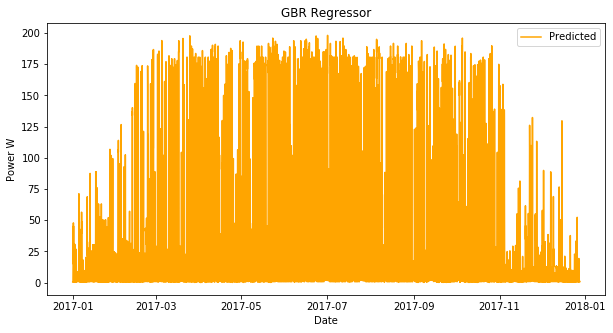

In [128]:
X_orig,X_no,y_orig,y_no=train_test_split(feature_konz,feature_konz,train_size=.99,random_state=0,shuffle=False)

yhat=gbr.predict(X_orig)

yhat=pd.DataFrame(yhat,columns=['Predicted Energy Wh'])
yhat.index=X_orig.index

#Plotting predicted solar production
plt.figure(figsize=(10,5))
line2,=plt.plot(yhat.abs(),'orange',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Power W')
plt.title('GBR Regressor')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

## PV power generation kWh by the proposed community

Text(0.5, 1.0, 'GBR Regressor')

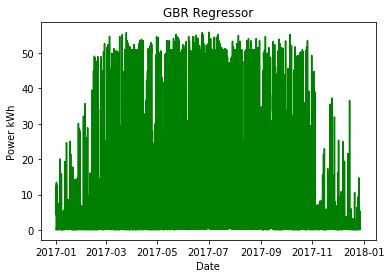

In [129]:
solar_gen_2017=yhat.abs()
solar_gen_2017=solar_gen_2017*(282/1000) #282 solar rooftop PV, divide by 1000 to convert into kWh
plt.plot(solar_gen_2017,'green')
plt.xlabel('Date')
plt.ylabel('Power kWh')
plt.title('GBR Regressor')
#solar_gen_2017.to_csv("community solar generation kWh.csv") #For output CSV file remove '#'

### Ploting average hourly PV production by community

<Figure size 720x360 with 0 Axes>

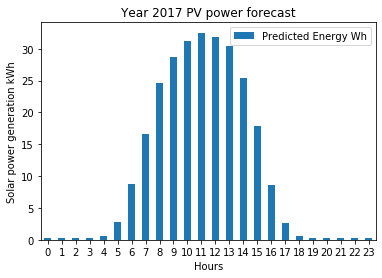

In [130]:
hour = (solar_gen_2017.assign(hour=solar_gen_2017.index.hour
                    ))
hours={}

i=0

for i in range(24):
    hours[i]=hour.loc[hour['hour'].isin([i])].iloc[:,0:1].mean().abs()
    
avg_sol=pd.DataFrame.from_dict(hours).T
#avg_sol.to_csv("Average year community solar generation kWh.csv") #For output CSV file remove '#'
plt.figure(figsize=(10,5))
ax = avg_sol.plot.bar(rot=0)
plt.xlabel("Hours")
plt.ylabel("Solar power generation kWh")
plt.title("Year 2017 PV power forecast")
plt.show()

# Konstanz load consumption forecasting of household buildings

## Importing load data

In [131]:
load = pd.read_csv('load.csv',parse_dates=[1])
load = load.set_index("utc_timestamp")
dt=pd.to_datetime(load.index)
load.index=dt
load.drop(['cet_cest_timestamp','interpolated'], inplace=True, axis=1)
load=load.fillna(load.mean())
load.head()

,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,DE_KN_industrial3_area_room_2,...,DE_KN_residential5_grid_import,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-11 17:00:00+00:00,221568.888712,4520.493934,3545.317203,7997.36058,10729.835447,826.647457,503.753457,8490.762617,3148.961735,14653.781672,...,4690.131494,294.520565,244.468436,457.528765,45.885397,100.862715,2179.05516,4208.442018,10043.197604,38.22966
2014-12-11 18:00:00+00:00,221568.888712,4520.493934,3545.317203,7997.36058,10729.835447,826.647457,503.753457,8490.762617,3148.961735,14653.781672,...,4690.131494,294.520565,244.468436,457.528765,45.885397,100.862715,2179.05516,4208.442018,10043.197604,38.22966
2014-12-11 19:00:00+00:00,221568.888712,4520.493934,3545.317203,7997.36058,10729.835447,826.647457,503.753457,8490.762617,3148.961735,14653.781672,...,4690.131494,294.520565,244.468436,457.528765,45.885397,100.862715,2179.05516,4208.442018,10043.197604,38.22966
2014-12-11 20:00:00+00:00,221568.888712,4520.493934,3545.317203,7997.36058,10729.835447,826.647457,503.753457,8490.762617,3148.961735,14653.781672,...,4690.131494,294.520565,244.468436,457.528765,45.885397,100.862715,2179.05516,4208.442018,10043.197604,38.22966
2014-12-11 21:00:00+00:00,221568.888712,4520.493934,3545.317203,7997.36058,10729.835447,826.647457,503.753457,8490.762617,3148.961735,14653.781672,...,4690.131494,294.520565,244.468436,457.528765,45.885397,100.862715,2179.05516,4208.442018,10043.197604,38.22966


### Subtracting

In [132]:
i=1
loads={}
for i in range(len(load)):
    loads[i]=load.iloc[i]-load.iloc[i-1]

act_loads=pd.DataFrame.from_dict(loads).T
act_loads.index=load.iloc[0:len(load)].index
act_loads

,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,DE_KN_industrial3_area_room_2,...,DE_KN_residential5_grid_import,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-11 17:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4083.668351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-11 18:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-11 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-11 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-11 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01 18:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.808496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-01 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.357031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-01 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.325195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Assigning datetime features

In [133]:
#Extracting some features from the date/time
final_df = (act_loads.assign(year = act_loads.index.year
                        ,month = act_loads.index.month
                     ,day = act_loads.index.day
                     ,hour=act_loads.index.hour)
           )

final_df

,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,DE_KN_industrial3_area_room_2,...,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,year,month,day,hour
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-11 17:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2014,12,11,17
2014-12-11 18:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2014,12,11,18
2014-12-11 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2014,12,11,19
2014-12-11 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2014,12,11,20
2014-12-11 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2014,12,11,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01 18:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,1,18
2019-05-01 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,1,19
2019-05-01 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,5,1,20


## 2016 actual load konstanz

In [134]:
load_1=final_df.loc[final_df['year'].isin([2016])]
load_1=load_1[['DE_KN_residential1_grid_import']]
load_1

,DE_KN_residential1_grid_import
utc_timestamp,
2016-01-01 00:00:00+00:00,0.353516
2016-01-01 01:00:00+00:00,0.359375
2016-01-01 02:00:00+00:00,0.380859
2016-01-01 03:00:00+00:00,0.388672
2016-01-01 04:00:00+00:00,0.497559
...,...
2016-12-31 19:00:00+00:00,0.385742
2016-12-31 20:00:00+00:00,0.444336
2016-12-31 21:00:00+00:00,0.405273


### Building-1 hourly average load consumption in Febraury 2017 with PV

<Figure size 720x360 with 0 Axes>

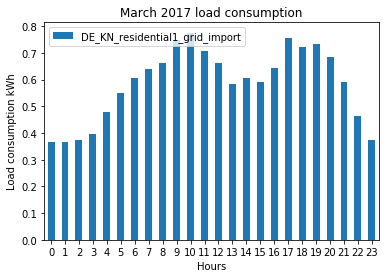

In [135]:
load_1 = (load_1.assign(hour=load_1.index.hour))
hours={}
i=0

for i in range(24):
    hours[i]=load_1.loc[load_1['hour'].isin([i])].iloc[:,0:1].mean()

avg_load1=pd.DataFrame.from_dict(hours).T

plt.figure(figsize=(10,5))
ax = avg_load1.plot.bar(rot=0)
plt.xlabel("Hours")
plt.ylabel("Load consumption kWh")
plt.title("March 2017 load consumption")
plt.show()

### Average household daily kWh consumption, February 2017

In [136]:
print("Average household consumption per day kWh 2016: ", load_1.iloc[:,0].sum(),' kWh')

Average household consumption per day kWh 2016:  5151.69824219  kWh


### Building-2 hourly average load consumption without PV

In [137]:
load_2=final_df.loc[final_df['year'].isin([2016])]
load_2=load_2[['DE_KN_residential5_grid_import']]
load_2

,DE_KN_residential5_grid_import
utc_timestamp,
2016-01-01 00:00:00+00:00,0.599976
2016-01-01 01:00:00+00:00,0.559937
2016-01-01 02:00:00+00:00,0.515015
2016-01-01 03:00:00+00:00,0.430054
2016-01-01 04:00:00+00:00,0.255005
...,...
2016-12-31 19:00:00+00:00,0.979980
2016-12-31 20:00:00+00:00,0.562744
2016-12-31 21:00:00+00:00,0.350098


<Figure size 720x360 with 0 Axes>

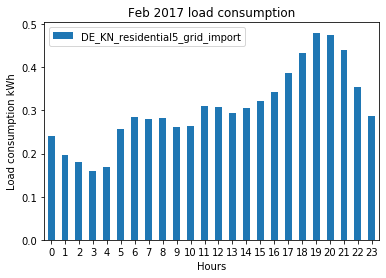

In [138]:
load_2 = (load_2.assign(hour=load_2.index.hour))
hours={}
i=0

for i in range(24):
    hours[i]=load_2.loc[load_2['hour'].isin([i])].iloc[:,0:1].mean()

avg_load2=pd.DataFrame.from_dict(hours).T

plt.figure(figsize=(10,5))
ax = avg_load2.plot.bar(rot=0)
plt.xlabel("Hours")
plt.ylabel("Load consumption kWh")
plt.title("Feb 2017 load consumption")
plt.show()

In [139]:
print("Average household consumption per day kWh 2016: ", load_2.iloc[:,0].sum(),' kWh')

Average household consumption per day kWh 2016:  2676.723917641  kWh


### Building-3 hourly average load consumption with PV

In [140]:
load_3=final_df.loc[final_df['year'].isin([2016])]
load_3=load_3[['DE_KN_residential3_circulation_pump','DE_KN_residential3_dishwasher','DE_KN_residential3_freezer',
              'DE_KN_residential3_refrigerator','DE_KN_residential3_washing_machine']]
load_3['total load kWh']=load_3.iloc[:,:].sum(axis=1)
load_3=load_3['total load kWh'].to_frame()
load_3

,total load kWh
utc_timestamp,
2016-01-01 00:00:00+00:00,0.088313
2016-01-01 01:00:00+00:00,0.086522
2016-01-01 02:00:00+00:00,0.098902
2016-01-01 03:00:00+00:00,0.076599
2016-01-01 04:00:00+00:00,0.113680
...,...
2016-12-31 19:00:00+00:00,0.322309
2016-12-31 20:00:00+00:00,0.147405
2016-12-31 21:00:00+00:00,0.110580


<Figure size 720x360 with 0 Axes>

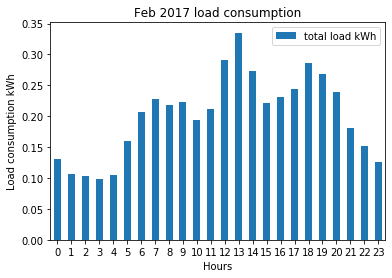

In [141]:
load_3 = (load_3.assign(hour=load_3.index.hour))
hours={}
i=0

for i in range(24):
    hours[i]=load_3.loc[load_3['hour'].isin([i])].iloc[:,0:1].mean()

avg_load3=pd.DataFrame.from_dict(hours).T

plt.figure(figsize=(10,5))
ax = avg_load3.plot.bar(rot=0)
plt.xlabel("Hours")
plt.ylabel("Load consumption kWh")
plt.title("Feb 2017 load consumption")
plt.show()

In [142]:
print("Average household consumption per day kWh 2016: ", load_3.iloc[:,0].sum(),' kWh')

Average household consumption per day kWh 2016:  1769.3569637800001  kWh


### Building-4 hourly average load consumption with PV

In [143]:
load_4=final_df.loc[final_df['year'].isin([2016])]
load_4=load_4[['DE_KN_residential4_dishwasher','DE_KN_residential4_ev','DE_KN_residential4_freezer',
              'DE_KN_residential4_heat_pump','DE_KN_residential4_refrigerator','DE_KN_residential4_washing_machine']]
load_4['total load kWh']=load_4.iloc[:,:].sum(axis=1)
load_4=load_4['total load kWh'].to_frame()
load_4

,total load kWh
utc_timestamp,
2016-01-01 00:00:00+00:00,0.643867
2016-01-01 01:00:00+00:00,0.480494
2016-01-01 02:00:00+00:00,0.666027
2016-01-01 03:00:00+00:00,0.576355
2016-01-01 04:00:00+00:00,0.520802
...,...
2016-12-31 19:00:00+00:00,0.614037
2016-12-31 20:00:00+00:00,1.075043
2016-12-31 21:00:00+00:00,0.626007


<Figure size 720x360 with 0 Axes>

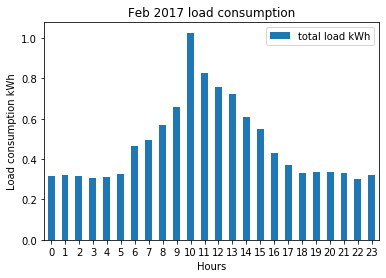

In [144]:
load_4 = (load_4.assign(hour=load_4.index.hour))
hours={}
i=0

for i in range(24):
    hours[i]=load_4.loc[load_4['hour'].isin([i])].iloc[:,0:1].mean()

avg_load4=pd.DataFrame.from_dict(hours).T

plt.figure(figsize=(10,5))
ax = avg_load4.plot.bar(rot=0)
plt.xlabel("Hours")
plt.ylabel("Load consumption kWh")
plt.title("Feb 2017 load consumption")
plt.show()

In [145]:
print("Average household consumption per day kWh 2016: ", load_4.iloc[:,0].sum(),' kWh')

Average household consumption per day kWh 2016:  4148.240352757  kWh


# Forming community of Mondrauteweg 6, Konstanz, Germany

### Six large buildings approximate hourly load 

In [146]:
large_buildings=avg_load1*6
large_buildings.rename(columns={'DE_KN_residential1_grid_import':'Large buildings kWh'}, inplace=True)
large_buildings.tail()

,Large buildings kWh
19,4.394633
20,4.107014
21,3.544612
22,2.788828
23,2.246841


### Three medium-small buildings approximate hourly load 

In [147]:
medium_small_buildings=avg_load2*3
medium_small_buildings.rename(columns={'DE_KN_residential5_grid_import':'Medium small buildings kWh'}, inplace=True)
medium_small_buildings.tail()

,Medium small buildings kWh
19,1.440729
20,1.423702
21,1.318369
22,1.059661
23,0.859057


### Seven small buildings approximate hourly load 

In [148]:
small_buildings=avg_load3*7
small_buildings.rename(columns={'total load kWh':'Small Buildings kWh'}, inplace=True)
small_buildings.tail()

,Small Buildings kWh
19,1.878929
20,1.670606
21,1.270454
22,1.066799
23,0.878992


### Six medium-large buildings approximate hourly load 

In [149]:
medium_large_buildings=avg_load4*6
medium_large_buildings.rename(columns={'total load kWh':'Medium-large Buildings kWh'}, inplace=True)
medium_large_buildings.tail()

,Medium-large Buildings kWh
19,2.031403
20,2.016699
21,1.998982
22,1.812828
23,1.917120


## Total community load kWh 2016 hourly average 

In [150]:
total_comm_load=pd.concat([large_buildings,small_buildings,medium_large_buildings,medium_small_buildings],axis=1)
total_comm_load.tail()

,Large buildings kWh,Small Buildings kWh,Medium-large Buildings kWh,Medium small buildings kWh
19,4.394633,1.878929,2.031403,1.440729
20,4.107014,1.670606,2.016699,1.423702
21,3.544612,1.270454,1.998982,1.318369
22,2.788828,1.066799,1.812828,1.059661
23,2.246841,0.878992,1.917120,0.859057


In [151]:
total_comm_load['total community load kWh']=total_comm_load.iloc[:,:].sum(axis=1)
total_comm_load=total_comm_load['total community load kWh'].to_frame()
total_comm_load.tail()

,total community load kWh
19,9.745694
20,9.218021
21,8.132417
22,6.728117
23,5.902010


In [152]:
#total_comm_load.to_csv("community load kwh.csv") #For output CSV file remove '#'
#total_solar.to_csv("community solar generation Wh.csv")*282  #For output CSV file remove '#'

In [153]:
total_load=pd.concat([load_1*6,load_2*3,load_3*7,load_4*6],axis=1)
total_load=total_load.drop(total_load['hour'],axis=1)
total_load['total community load kWh']=total_load.iloc[:,:].sum(axis=1)
#total_load=total_load['total community load kWh'].to_frame()
total_load=total_load['total community load kWh']
com_load=total_load
com_load

utc_timestamp
2016-01-01 00:00:00+00:00     8.402415
2016-01-01 01:00:00+00:00     7.324678
2016-01-01 02:00:00+00:00     8.518679
2016-01-01 03:00:00+00:00     7.616516
2016-01-01 04:00:00+00:00     7.670942
                               ...    
2016-12-31 19:00:00+00:00    11.194780
2016-12-31 20:00:00+00:00    11.836338
2016-12-31 21:00:00+00:00     8.012039
2016-12-31 22:00:00+00:00    12.739908
2016-12-31 23:00:00+00:00     6.997264
Name: total community load kWh, Length: 8784, dtype: float64

# Forecasting community load conusmption kWh

## 2016 year Household load consumption kWh

In [154]:
#Extracting some features from the date/time
final_df = (wea_data.assign(year = wea_data.index.year
                        ,month = wea_data.index.month
                     ,day = wea_data.index.day
                     ,hours=wea_data.index.hour
                     ,week = wea_data.index.isocalendar().week
                     ,week_day = wea_data.index.weekday)
           )

feature_load=final_df.loc[final_df['year'].isin([2016])]
feature_load

,AirTemp,AlbedoDaily,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,GtiFixedTilt,...,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,year,month,day,hours,week,week_day
PeriodStart,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,2.9,0.15,-33,92.8,2.5,0,0,0,0,0,...,932.0,200,1.1,152,2016,1,1,0,53,4
2016-01-01 01:00:00+00:00,2.6,0.15,-56,61.0,2.2,0,0,0,0,0,...,932.2,216,1.0,145,2016,1,1,1,53,4
2016-01-01 02:00:00+00:00,2.3,0.15,-72,48.7,1.9,0,0,0,0,0,...,932.4,233,1.0,136,2016,1,1,2,53,4
2016-01-01 03:00:00+00:00,2.1,0.15,-85,22.5,1.7,0,0,0,0,0,...,932.5,239,0.9,126,2016,1,1,3,53,4
2016-01-01 04:00:00+00:00,2.0,0.15,-96,6.0,1.6,0,0,0,0,0,...,932.5,233,0.8,116,2016,1,1,4,53,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00+00:00,-3.9,0.21,84,0.0,-7.1,0,0,0,0,0,...,935.8,180,1.6,128,2016,12,31,19,52,5
2016-12-31 20:00:00+00:00,-4.4,0.21,70,0.0,-7.6,0,0,0,0,0,...,935.3,179,1.6,137,2016,12,31,20,52,5
2016-12-31 21:00:00+00:00,-4.5,0.21,53,0.0,-7.7,0,0,0,0,0,...,934.8,180,1.7,146,2016,12,31,21,52,5


 0  AirTemp= 0.04
 1 AlbedoDaily= 0.04
 2  Azimuth= 0.07
 3 CloudOpacity= 0.00
 4 DewpointTemp= 0.06
 5      Dhi= 0.04
 6      Dni= 0.00
 7      Ebh= 0.01
 8      Ghi= 0.03
 9 GtiFixedTilt= 0.04
10 GtiTracking= 0.02
11 PrecipitableWater= 0.02
12 RelativeHumidity= 0.01
13 SnowDepth= 0.15
14 SurfacePressure= 0.00
15 WindDirection10m= 0.00
16 WindSpeed10m= 0.01
17   Zenith= 0.06
18     year= 0.00
19    month= 0.16
20      day= 0.00
21    hours= 0.12
22     week= 0.12
23 week_day= 0.01


C:\Users\TALAL.Talal.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


<StemContainer object of 3 artists>

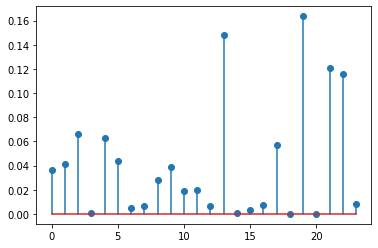

In [155]:
#Calculating feature importance
X_train,X_test,y_train,y_test=train_test_split(feature_load,total_load,train_size=0.75,test_size=0.25,random_state=0,shuffle=False)

gbr = GradientBoostingRegressor(max_features=5,n_estimators=1050,learning_rate=0.0009,
                                     max_depth=3,random_state=0,validation_fraction=1)
gbr.fit(X_train, y_train)
for i in range(len(feature_load.columns)):
    print("%2d %8s=%5.2f" % (i,feature_load.columns[i], gbr.feature_importances_[i]))
plt.stem(gbr.feature_importances_)

In [156]:
feature_load=feature_load[['Azimuth','SnowDepth','month','week','hours']]
feature_load

,Azimuth,SnowDepth,month,week,hours
PeriodStart,,,,,
2016-01-01 00:00:00+00:00,-33,0.2,1,53,0
2016-01-01 01:00:00+00:00,-56,0.2,1,53,1
2016-01-01 02:00:00+00:00,-72,0.2,1,53,2
2016-01-01 03:00:00+00:00,-85,0.2,1,53,3
2016-01-01 04:00:00+00:00,-96,0.2,1,53,4
...,...,...,...,...,...
2016-12-31 19:00:00+00:00,84,0.4,12,52,19
2016-12-31 20:00:00+00:00,70,0.4,12,52,20
2016-12-31 21:00:00+00:00,53,0.4,12,52,21


CV score.......... 0.19900015124068557
Training score.... 0.38407444385013667
Test score........ 0.34193413280590645


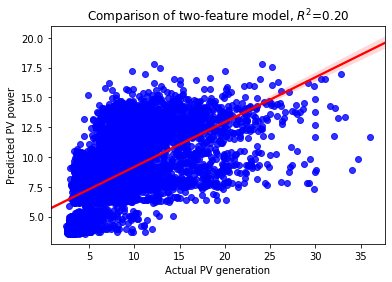

In [157]:
from sklearn.model_selection import GridSearchCV

X_train,X_test,y_train,y_test=train_test_split(feature_load,total_load,train_size=.6,random_state=0,shuffle=False)


    
gbr_load = GradientBoostingRegressor(n_estimators=500,learning_rate=0.09,
                                     max_depth=1,random_state=1,subsample= 0.5)
"""
search_grid={'n_estimators':[100,500,1500],'learning_rate':[0.009,.09,.9],'max_depth':[1,2,3,4],'subsample':[.3,.75,1],'random_state':[0,1]}
search=GridSearchCV(estimator=gbr_load,param_grid=search_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=5)
search.fit(X_train,y_train)
search.best_params_
"""
gbr_load.fit(X_train, y_train)

yhat_load1=gbr_load.predict(X_train)

RsquaredCV=cross_val_score(gbr_load, X_test, y_test, cv=5).mean()
RsquaredTR=gbr_load.score(X_train,y_train)

sns.regplot(x=y_train,y=yhat_load1, line_kws={"color": "red"},scatter_kws={"color": "blue"})

yhat_load=gbr_load.predict(X_test)
plt.xlabel('Actual PV generation')
plt.ylabel('Predicted PV power')
plt.title('Comparison of two-feature model, $R^2$=%3.2f' % RsquaredCV)
print("CV score..........", RsquaredCV)
print("Training score....", RsquaredTR)
print("Test score........",r2_score(y_true=y_test,y_pred=yhat_load))

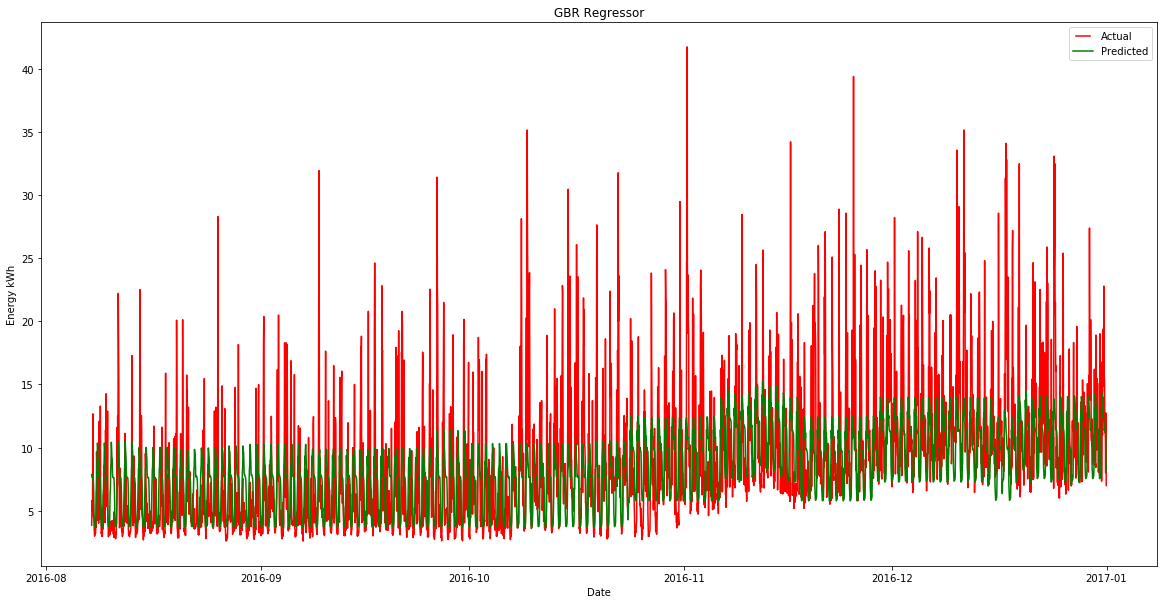

In [158]:
yhat_load=pd.DataFrame(yhat_load,columns=['Predicted Energy'])
yhat_load1=pd.DataFrame(yhat_load1,columns=['Predicted Energy'])
yhat_load.index=y_test.index
yhat_load1.index=y_train.index
#Plotting predicted solar production
plt.figure(figsize=(20,10))
line1,=plt.plot(y_test,'r',label='Actual')
line2,=plt.plot(yhat_load,'green',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Energy kWh')
plt.title('GBR Regressor')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

In [159]:
#Extracting some features from the date/time
final_df = (wea_data.assign(year = wea_data.index.year
                        ,month = wea_data.index.month
                     ,day = wea_data.index.day
                     ,hours=wea_data.index.hour
                     ,week = wea_data.index.isocalendar().week
                     ,week_day = wea_data.index.weekday 
                     ,hour=wea_data.index.hour)
           )

feature_load=final_df.loc[final_df['year'].isin([2017])]
feature_load=feature_load[['Azimuth','SnowDepth','month','week','hours']]
feature_load

,Azimuth,SnowDepth,month,week,hours
PeriodStart,,,,,
2017-01-01 00:00:00+00:00,-33,0.6,1,52,0
2017-01-01 01:00:00+00:00,-56,0.6,1,52,1
2017-01-01 02:00:00+00:00,-72,0.6,1,52,2
2017-01-01 03:00:00+00:00,-85,0.6,1,52,3
2017-01-01 04:00:00+00:00,-96,0.6,1,52,4
...,...,...,...,...,...
2017-12-31 19:00:00+00:00,84,12.0,12,52,19
2017-12-31 20:00:00+00:00,70,12.0,12,52,20
2017-12-31 21:00:00+00:00,53,12.2,12,52,21


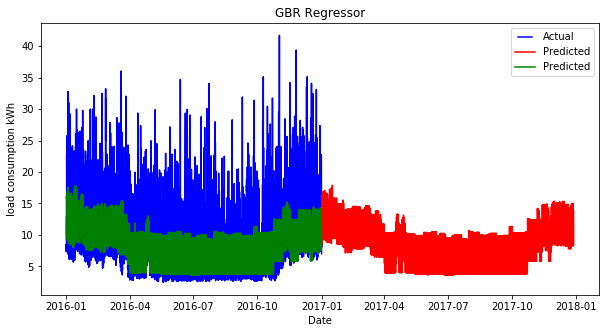

In [160]:
X_orig,X_no,y_orig,y_no=train_test_split(feature_load,feature_load,train_size=.99,random_state=0,shuffle=False)

yhat2=gbr_load.predict(X_orig)

yhat2=pd.DataFrame(yhat2,columns=['Predicted load consumption kWh'])
yhat2.index=X_orig.index
load_con_2017=yhat2
#Plotting predicted load kWh consumption
plt.figure(figsize=(10,5))
line1,=plt.plot(total_load,'blue',label='Actual')
line2,=plt.plot(yhat2,'red',label='Predicted')
line3,=plt.plot(yhat_load,'green',label='Predicted')
line4,=plt.plot(yhat_load1,'green')
plt.xlabel('Date')
plt.ylabel('load consumption kWh')
plt.title('GBR Regressor')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=6)})
plt.show()

<Figure size 720x360 with 0 Axes>

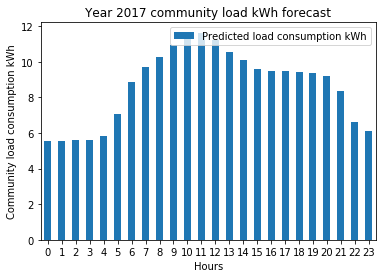

In [161]:
hour = (load_con_2017.assign(hour=load_con_2017.index.hour
                    ))
hours={}

i=0

for i in range(24):
    hours[i]=hour.loc[hour['hour'].isin([i])].iloc[:,0:1].mean().abs()
    
avg_sol=pd.DataFrame.from_dict(hours).T
#avg_sol.to_csv("Average year community load kWh.csv") #For output CSV file remove '#'
plt.figure(figsize=(10,5))
ax = avg_sol.plot.bar(rot=0)
plt.xlabel("Hours")
plt.ylabel("Community load consumption kWh")
plt.title("Year 2017 community load kWh forecast")
plt.show()
#load_con_2017.to_csv("community load kwh 2017.csv") #For output CSV file remove '#'

In [162]:
yhat_load1

,Predicted Energy
utc_timestamp,
2016-01-01 00:00:00+00:00,9.420564
2016-01-01 01:00:00+00:00,9.420564
2016-01-01 02:00:00+00:00,9.510910
2016-01-01 03:00:00+00:00,9.543778
2016-01-01 04:00:00+00:00,9.720919
...,...
2016-08-07 09:00:00+00:00,9.151003
2016-08-07 10:00:00+00:00,10.353135
2016-08-07 11:00:00+00:00,10.018261
